This notebook aims to create a `warp_matrices` file which is an affine transformation that can align the captures of the Dual-MX camera system. This `warp_matrices` file will be applied to all the flights

1. Find a capture where there are sufficient features in the scene
2. Make sure that the height of the capture > 35 m AGL


For best alignment results it's good to select a capture which has features which visible in all bands.  Man-made objects such as cars, roads, and buildings tend to work very well, while captures of only repeating crop rows tend to work poorly.  Remember, once a good transformation has been found for flight, it can be generally be applied across all of the images.

It's also good to use an image for alignment which is taken near the same level above ground as the rest of the flights. Above approximately 35m AGL, the alignement will be consistent. However, if images taken closer to the ground are used, such as panel images, the same alignment transformation will not work for the flight data.  

In [41]:
import micasense.imageset as imageset
import micasense.capture as capture
import cv2
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils
import os, glob
import json
import tqdm
import pickle #This library will maintain the format as well
import importlib
import radiometric_calib_utils
import mutils
importlib.reload(radiometric_calib_utils)
importlib.reload(mutils)
import radiometric_calib_utils as rcu
import mutils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [42]:
panel_fp = rcu.load_panel_fp(r"saved_data\panel_fp.json")
panel_albedo = mutils.load_pickle(r"saved_data\panel_albedo.ob")
center_wavelengths = mutils.load_pickle(r"saved_data\center_wavelengths_by_band.ob")
dls_panel_irr = mutils.load_pickle(r"saved_data\dls_panel_irr.ob")
dls_panel_irr_calibration = mutils.load_pickle(r"saved_data\dls_panel_irr_calibration.ob")

In [43]:
dir_fp = list(panel_fp.keys())[0]
cap_fp = panel_fp[dir_fp][0]
print(dir_fp)
print(cap_fp)
cap = capture.Capture.from_filelist(cap_fp)
panel_radiance = cap.panel_radiance()
panel_radiance_to_irradiance = lambda radiance,albedo: radiance*np.pi/albedo
panel_irradiance = [panel_radiance_to_irradiance(radiance,albedo) for radiance, albedo in zip(panel_radiance,panel_albedo)] #panel_radiance*np.pi/panel_albedo
print(panel_radiance)
print(panel_irradiance)

F:\surveys_10band\10thSur24Aug\F1\RawImg
['F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_1.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_2.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_3.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_4.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_5.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_6.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_7.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_8.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_9.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_10.tif']
[0.14419940967335684, 0.14471271888042647, 0.12094172591079055, 0.06896841919866718, 0.0929759757107048, 0.15087091514665077, 0.1612072629085932, 0.1277203362299739, 0.1114749870194063, 0.1025448013702902]
[0.9415761103285069, 0.9468795081555529, 0.7934240877207821, 0.45438546360628734, 0.6106870676172149, 0.9843989

## Plot reflectance without wrap homography but corrected for lens distortion

['F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0005_1.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0005_2.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0005_3.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0005_4.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0005_5.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0005_6.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0005_7.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0005_8.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0005_9.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0005_10.tif']


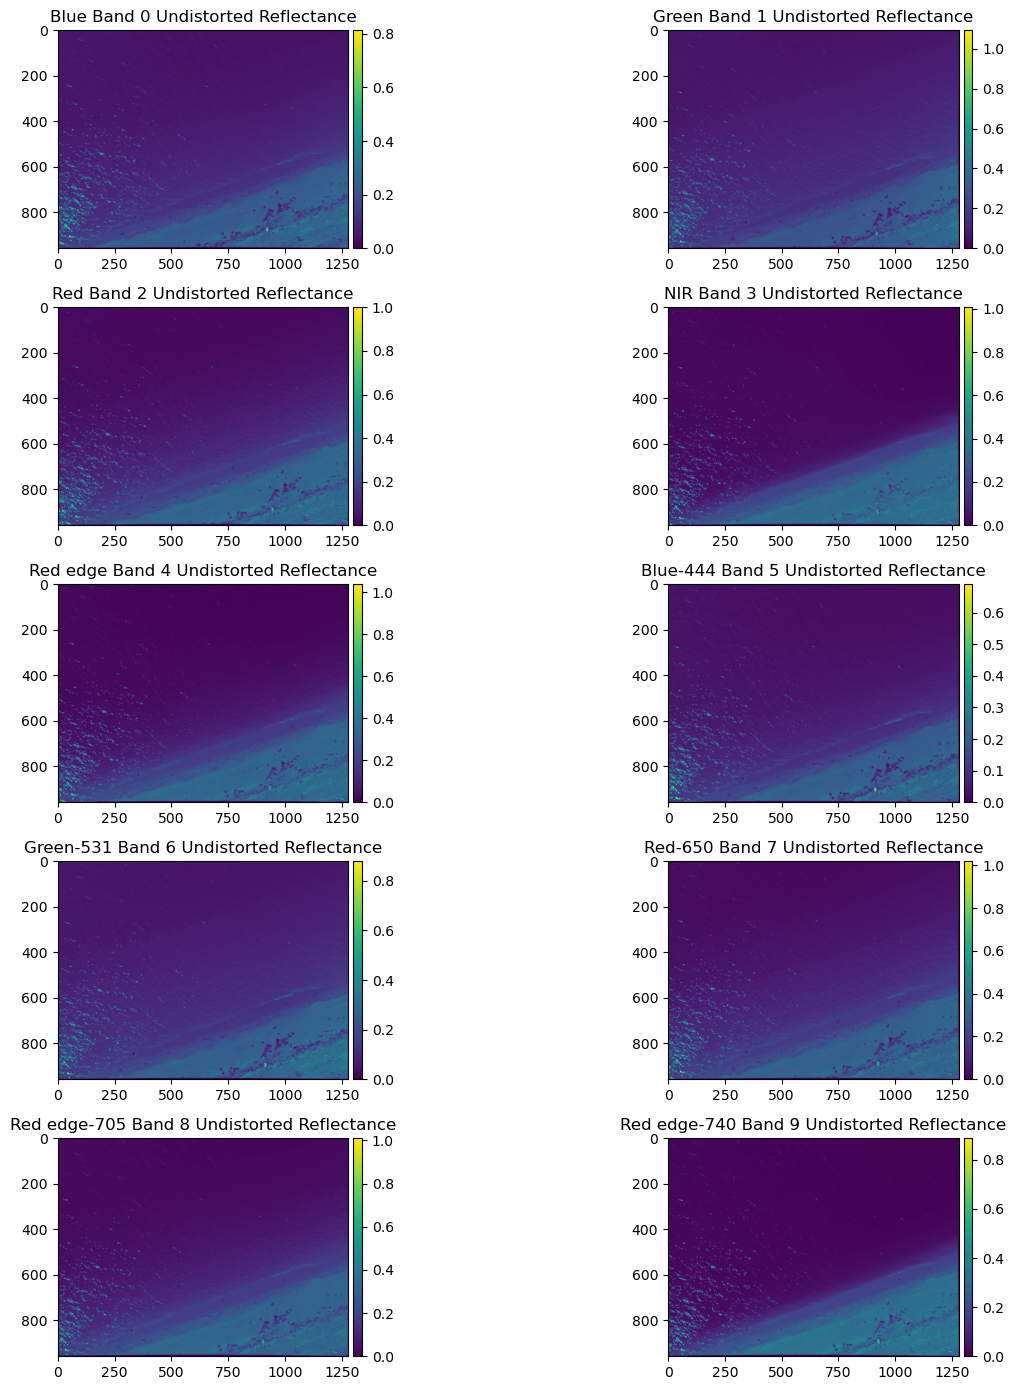

In [44]:
image_names = glob.glob(os.path.join(dir_fp,'IMG_0005_*.tif'))
image_names = mutils.order_bands_from_filenames(image_names)
print(image_names)
cap = capture.Capture.from_filelist(image_names)
cap.plot_undistorted_reflectance(panel_irradiance) #undistorted_reflectance

# Check height of images

In [45]:
imagePath = r"F:\surveys_10band\1stSur6Apr\F1\RawImg"
imgset = imageset.ImageSet.from_directory(imagePath)
data, columns = imgset.as_nested_lists()
df = pd.DataFrame.from_records(data, index='timestamp', columns=columns)
df.head()

Loading ImageSet from: F:\surveys_10band\1stSur6Apr\F1\RawImg


,latitude,longitude,altitude,capture_id,dls-yaw,dls-pitch,dls-roll,irr-475,irr-560,irr-668,irr-842,irr-717,irr-444,irr-531,irr-650,irr-705,irr-740
timestamp,,,,,,,,,,,,,,,,,
2022-04-06 03:14:37.372322+00:00,1.231912,103.630518,19.356,DKycxS4lBNEBIgMv7EMJ,2.770871,-0.053952,0.009055,1.732023,1.599768,1.368782,0.853344,1.054424,1.533242,1.637993,1.351430,1.195858,1.099124
2022-04-06 03:14:53.909274+00:00,1.231916,103.630518,19.297,5jF5NqJwx9jzq2YHKlkE,2.769937,-0.126348,0.006448,1.813087,1.675498,1.431167,0.893403,1.102981,1.607329,1.715373,1.414062,1.249963,1.148568
2022-04-06 03:25:09.599656+00:00,1.231914,103.630542,29.698,Ap1yoOOF2gVo6wFw4rgW,-3.096810,-0.248460,0.097935,1.596519,1.472876,1.255682,0.780899,0.962106,1.414741,1.508238,1.238478,1.093779,1.006241
2022-04-06 03:25:13.142936+00:00,1.231817,103.630522,36.184,Gc6eGH03htsNc081f9P8,-3.139642,-0.166312,0.107307,1.541424,1.422055,1.213235,0.753947,0.928812,1.365155,1.456089,1.196084,1.056527,0.972193
2022-04-06 03:25:14.995771+00:00,1.231747,103.630508,39.688,V7qXct9cNLM4WkjaDzzM,-3.133579,-0.173759,0.101554,1.519193,1.401495,1.196080,0.743011,0.915341,1.345082,1.435008,1.178924,1.041485,0.958449


# Wrap homography with rig relatives

In [46]:
warp_mode = cv2.MOTION_HOMOGRAPHY
warp_matrices = cap.get_warp_matrices()
img_type = "reflectance"
cropped_dimensions,edges = imageutils.find_crop_bounds(cap,warp_matrices)
im_aligned = imageutils.aligned_capture(cap, warp_matrices, warp_mode, cropped_dimensions, None, img_type=img_type)


c:\Users\xinmatrix\anaconda3\envs\micasense\lib\site-packages\numpy\matrixlib\defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
d:\PAKHUIYING\Image_processing\F3_raw_images\Simulate_sun_glint\micasense\imageutils.py:408: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pts = np.array([pts], dtype=np.float)


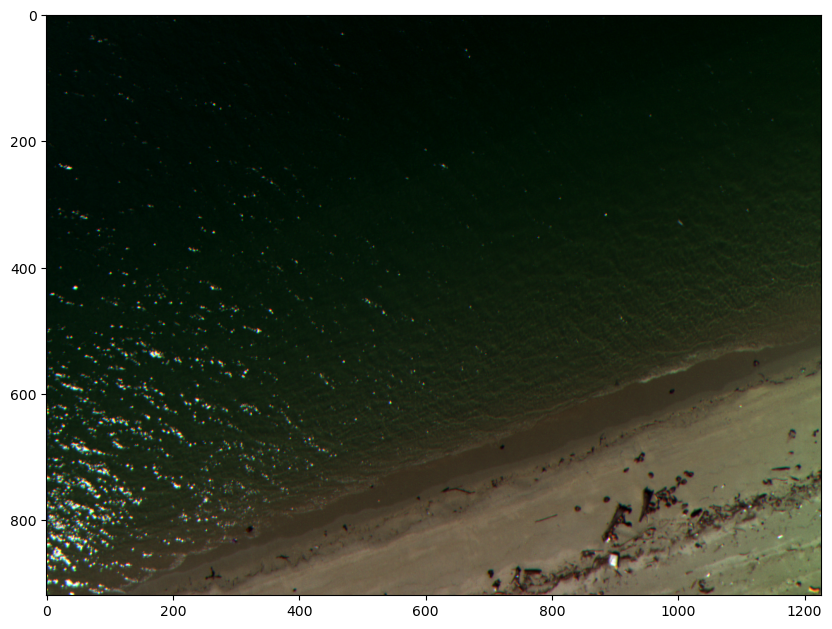

array([[[1.5981667e-03, 4.9036410e-02, 1.2980723e-02],
        [0.0000000e+00, 3.3452936e-02, 1.5800118e-02],
        [0.0000000e+00, 4.0007778e-02, 1.7352216e-02],
        ...,
        [5.0770649e-04, 5.5363141e-02, 9.6690673e-03],
        [9.3657152e-05, 5.5935059e-02, 8.8016512e-03],
        [0.0000000e+00, 6.0974833e-02, 1.5520465e-02]],

       [[1.2596724e-02, 6.9964603e-02, 2.3263110e-02],
        [3.9537062e-04, 4.9380653e-02, 1.5073821e-02],
        [0.0000000e+00, 3.9576478e-02, 1.9182665e-02],
        ...,
        [2.5205815e-03, 6.0115591e-02, 9.2912866e-03],
        [0.0000000e+00, 6.2497549e-02, 6.6092913e-03],
        [0.0000000e+00, 6.2879972e-02, 1.1448490e-02]],

       [[2.3863884e-02, 5.6655396e-02, 2.2941250e-02],
        [4.8502437e-03, 4.2495869e-02, 1.8649464e-02],
        [0.0000000e+00, 5.3413186e-02, 2.1656472e-02],
        ...,
        [5.3615496e-03, 6.0444392e-02, 1.0329173e-02],
        [0.0000000e+00, 6.0934152e-02, 7.7866339e-03],
        [0.0000000e+00

In [47]:
mutils.get_rgb(im_aligned)

In [48]:
image_names = glob.glob(os.path.join(dir_fp,'IMG_0005_*.tif'))
image_names = mutils.order_bands_from_filenames(image_names)
print(image_names)
cap = capture.Capture.from_filelist(image_names)

['F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0005_1.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0005_2.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0005_3.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0005_4.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0005_5.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0005_6.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0005_7.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0005_8.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0005_9.tif', 'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0005_10.tif']


c:\Users\xinmatrix\anaconda3\envs\micasense\lib\site-packages\numpy\matrixlib\defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
d:\PAKHUIYING\Image_processing\F3_raw_images\Simulate_sun_glint\micasense\imageutils.py:408: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pts = np.array([pts], dtype=np.float)


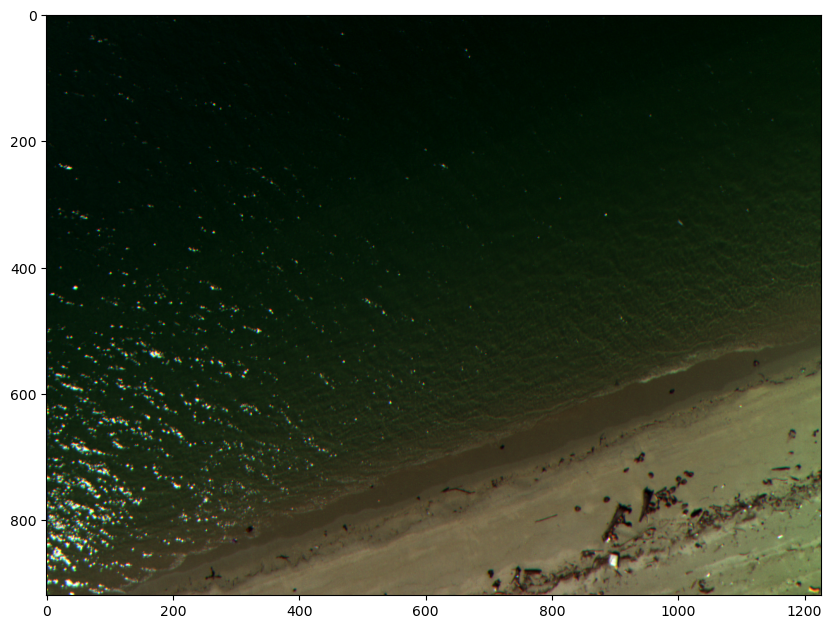

In [49]:
img = mutils.align_captures(cap)
img = mutils.get_rgb(img)

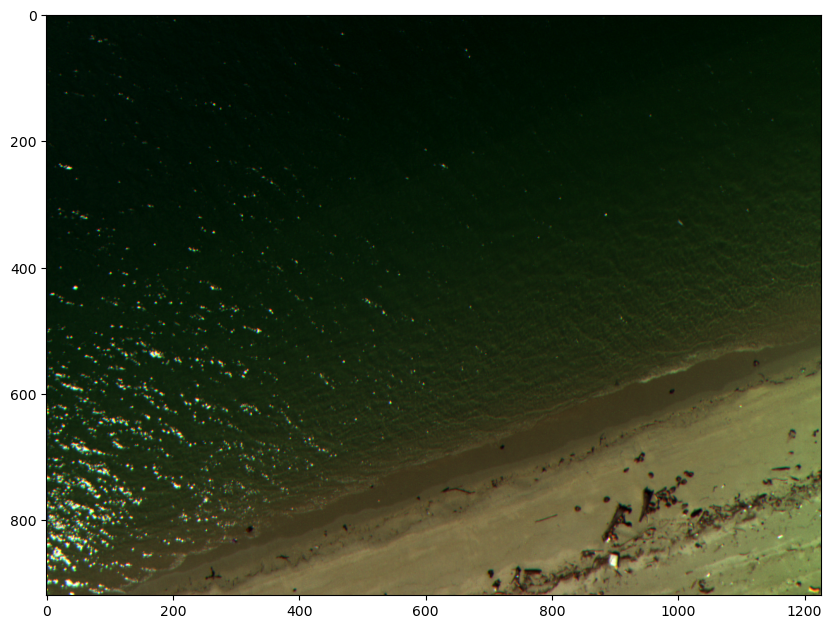

In [50]:
cf = rcu.CorrectionFactor(panel_radiance,dls_panel_irr_calibration).correction_factor
corrected_img = rcu.radiometric_corrected_aligned_captures(cap,cf)
corrected_img = mutils.get_rgb(corrected_img)